In [1]:
import xarray as xr # Import the Xarray package
import matplotlib.pyplot as plt # Plotting library
import numpy as np # Import the Numpy package
import cartopy,cartopy.crs as ccrs # Plot maps
import cartopy.feature as cfeature # Collection of points, lines and polygons
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER # Add gridlines and tick labels to a map
import cartopy.io.shapereader as shpreader # Oriented shapefile reader
from netCDF4 import Dataset # Read/Write NetCDF4 files
from datetime import datetime, timedelta # Basics Dates and time types
from matplotlib import cm # Colormap handling utilities
import metpy
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from utilities import loadCPT
from scipy.ndimage.filters import maximum_filter, minimum_filter
import scipy.ndimage as ndimage
from ecmwf.opendata import Client

In [2]:
def plot_maxmin_points_0(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):

        txt2 = ax.annotate('\n' + str(int(data[mxy[i], mxx[i]])), xy=(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]]),
                           xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), 
                color=color, size=14, clip_on=True, annotation_clip=True, fontweight='bold', 
                           horizontalalignment='center', verticalalignment='top',
                transform=ccrs.PlateCarree())  

In [3]:
ds13=xr.open_dataset('C:/Users/igorr/Downloads/OR_ABI-L2-LSTF-M6_G16_s20233161900203_e20233161909511_c20233161910403.nc')
ds13

<xarray.Dataset>
Dimensions:                                 (y: 1086, x: 1086, number_of_time_bounds: 2, number_of_image_bounds: 2, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2)
Coordinates:
  * y                                       (y) float32 0.1519 ... -0.1519
  * x                                       (x) float32 -0.1519 ... 0.1519
    t                                       datetime64[ns] ...
    y_image                                 float32 ...
    x_image                                 float32 ...
    retrieval_local_zenith_angle            float32 ...
    quantitative_local_zenith_angle         float32 ...
    solar_zenith_angle                      float32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/27)
    LST                                     (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    PQI                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    FPT_mitigation_flag                     float32 ...
    algorithm_dynamic_input_data_container  int32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-11-12T19:00:20.3Z
    time_coverage_end:         2023-11-12T19:09:51.1Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        376c8b68-d121-44d6-9b5a-d75fb3cec931

In [4]:
dat13 = ds13.metpy.parse_cf('LST')
dat13=dat13-273.15
geos = dat13.metpy.cartopy_crs

x = dat13.x
y = dat13.y

In [5]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(ds13.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
date=scan_start
# Scan's end time, converted to datetime object
scan_end = datetime.strptime(ds13.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(ds13.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(ds13['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))

Scan Start    : 2023-11-12 19:00:20.300000
Scan midpoint : 2023-11-12 19:05:05.700000
Scan End      : 2023-11-12 19:09:51.100000
File Created  : 2023-11-12 19:10:40.300000
Scan Duration : 9.50 minutes


In [6]:
cores=['#4b4947','#76726e','#989795','#b8b6b7','#d3d2d0','#bf0663','#fe0188','#ef379c','#f667b8','#ff90c6',
       '#6306bf','#7f00ff','#8826da','#a757ea','#c690ff','#0048be','#246afe','#3b77e9','#7babff','#99c3f9',
       '#034b51','#017e7e','#1492ae','#09c1da','#04fdfd','#004f00','#017e01','#01af02','#1dc41f','#2cef2c',
       '#85860b','#dedf13','#fef800','#fbf464','#fefeb8','#ff7f00','#fe9831','#fda950','#fec081','#fed8af',
       '#bb0101','#fe0000','#fe4040','#fb6260','#fd9190','#99550e','#b06f2b','#cb8d50','#e5b17e','#ffd8af',
       '#8f6153','#a27d73','#b1958c','#c5b1aa','#dbcec8','#e57aa4','#e58eb2','#e8a6c1','#ebbece','#e2d4db',
       ] 

my_cmap = ListedColormap(cores, name="my_cmap")

In [7]:
# xx,yy=np.meshgrid(dat13.x,dat13.y)

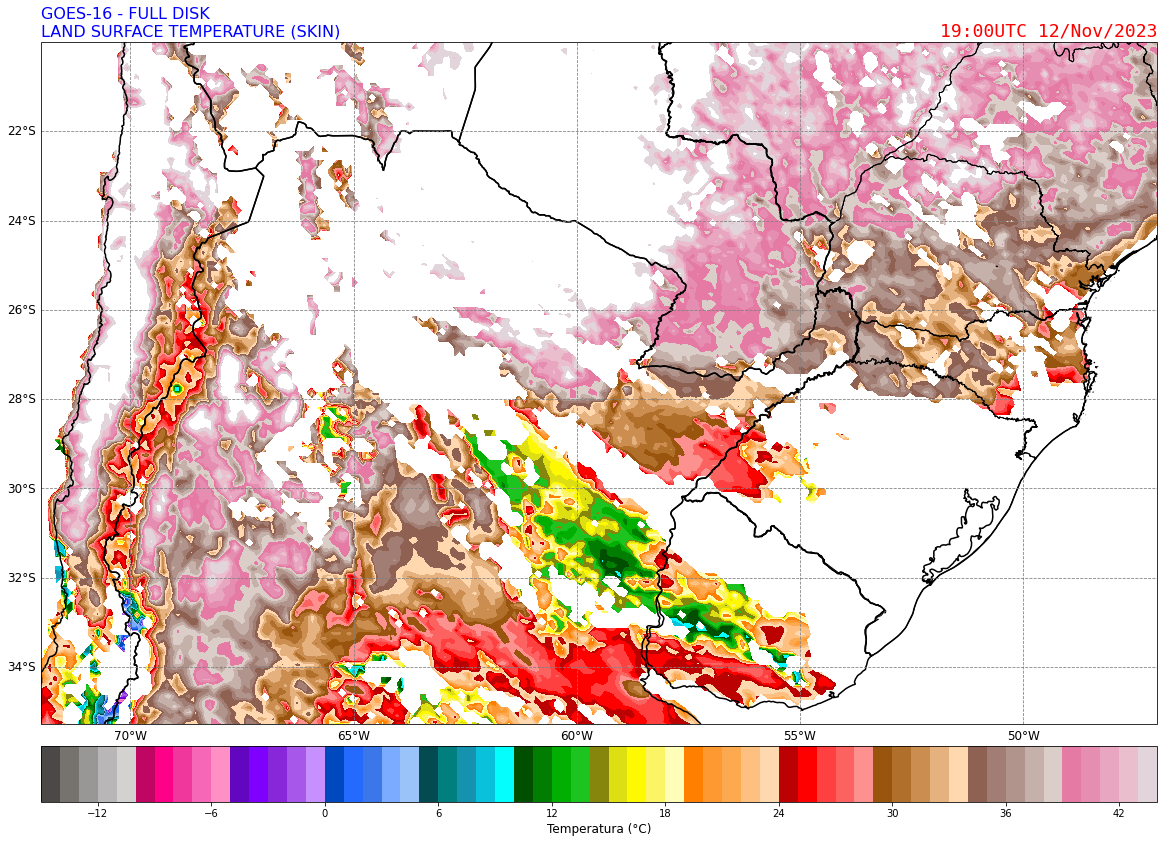

In [10]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="10m",edgecolor='k',linestyle='-',linewidth=0.3)
#ax.set_extent([-83,-34,12,-54]) #América do Sul
#ax.set_extent([-58,-47,-34,-22]) #Sul do Brasil
#ax.set_extent([-54.8,-47.9,-22.4,-26.8]) #Paraná
ax.set_extent([-72,-47,-20,-35])

im=ax.contourf(x,y,dat13,np.arange(-15,45,1),
               cmap=my_cmap,origin='upper',
               extent=(x.min(), x.max(), y.min(), y.max()),
               transform=geos)

#im1=ax.contour(x,y,dat13,np.arange(-15,45,4),
#             linewidths=0.2,
#              colors='white',
#              extent=(x.min(), x.max(), y.min(), y.max()),
#               transform=geos)
#ax.clabel(im1,inline=1,inline_spacing=0,fontsize='14',fmt='%i',rightside_up=True,colors='k')
#plot_maxmin_points_0(xx,yy,dat13,'min',10,symbol='mín',
#                   color='k',
                   
#                   transform=geos)

states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='k',facecolor='none',linestyle='-',linewidth=1.5)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='k',facecolor='none',linestyle='-',linewidth=1.)

g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)
g1.right_labels=False
g1.top_labels=False
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.06,orientation='horizontal')
cbar.set_label(label='Temperatura (°C)',size=12)

plt.title('GOES-16 - FULL DISK\nLAND SURFACE TEMPERATURE (SKIN)',
          fontsize=16,loc='left',color='blue')

plt.title('{}'.format(scan_start.strftime('%H:%MUTC %d/%b/%Y')),fontsize=18,loc='right',
          color='red',fontweight='normal',fontfamily='monospace')
plt.savefig('GOES16_LST_AS_'+scan_start.strftime('%H_%MUTC_%d_%b_%Y')+'.jpeg',dpi=300,bbox_inches='tight')